# Homework 04 - Applied ML

*Remarks for the easy reading of the work*:
The data in use are stored in the folder `Data`, the description is available [here](https://github.com/ADAEPFL/Homework/blob/master/04%20-%20Applied%20ML/DATA.md).
All the functions that are mentioned are stored in separate libraries that are specified at each step. For some of them the reading of the documentation is required to understand how certain results are obtained. 
The *Notebook* organisation is specified in the *Table of contents*.

__Important__: due to the precence of interactive plot, we suggest you to visualize the notebook using the following [link](http://nbviewer.jupyter.org/github/CriMenghini/ADA_Homeworks/blob/master/Homework_4/Hw_4.ipynb).

### Table of contents
1. [Predict the skin color of a soccer player](#task1)
    1. [Exploratory Data Analysis, Feature Selection and Feature engineering](#EDA)
     1. [Target variable](#target)
    2. [Baseline model](#baseline)
	3. [Find the model](#tuning)
	4. [*BONUS*](#bonus)
2. [Cluster players with dark and light skin colors](#task2)
    1. [Sub paragraph](#subparagraph1)

## 1. Predict the skin color of a soccer player <a name="task1"></a>

In this first task we train a *Random forest* classifier to be able to predict the skin color of a soccer player using the player description. In order to do so, we proceed pre-processing the data as first step then moving toward the choice of the model (interpret as the choice of parameters controlling the possible issues i.e. the *overfitting*). As required, we then switch to the inspection of the `feature_importances_` attribute and the discussion of the obtained results.

In [18]:
import os
import plotly
import numpy as np
import pandas as pd
import seaborn as sns  
from plots import *
import plotly.tools as tls
from functools import partial
import matplotlib.pyplot as plt 
from data_preprocessing import *
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
plotly.tools.set_credentials_file(username='crimenghini', api_key='t5q05yuxzu')
%matplotlib inline

In [2]:
# Import data 
data = pd.read_csv('Data/CrowdstormingDataJuly1st.csv', sep = ',')
# Take a look at the data head
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


### A. Exploratory Data Analysis, Feature Selection and Feature engineering <a name="EDA"></a>

### a. Target variable <a name="target"></a>

Before proceeding with the exploration of the features, we focuse our attention on the target variable (`rater1`, `rater2`). In this case we face the folliwing issues:
1. [*Absence of labels*](#absence): Not all the players have an `IDphoto`, thus the *raters* can not label the skin color. It results in a bunch of player not labeled. Since in this first task we work using the *Supervised* learning we drop out all the *dyads* that correspond to players whose picture is not available.

2. [*Inconsistency of labels*](#inconsistency): The labels assigned by the two raters for some players disagree. In order to control this inconsistency we think about different approaches. 
    - Compute the mean of the assigned scores. Whether the classification problem is set up as a *multiclassification* problem (five classes according to the `data description` - 0, 0.25, 0.5, 0.75, 1), if the disagreement of the two classes is greater than 0.25 (absolute value) the computation of the average implies the creation of new classes. Otherwise, whether the classification problem is simplified to the *binary* classification (all those players that have been labeled with $0 < values \leq 0.5$ belong to class 0, all those whose $0.5 < values \leq 1$) the values obtained computing the average can be easily assigned to one of the two classes.
    - Use the two scores vectors to train the model, defining a *multi target* model whether the problem is set up both as *multiclass* or *binary*.
        
3. [*Unbalanced sample*](#unbalance): the sample that we analyse turns to be *unbalanced*. It means that there are classes that are more present in the population. This verification leads to the necessity of using different metrics, rather the *simple* accuracy, to evaluate the model, and can be in some way faced using some tecniques to *rebalance* the sample.

#### 1. Absence of labels  <a name="absence"></a>

In [3]:
# Drop out the unlabeled players
data_clean = data[(data.photoID.notnull())]

Now we are left with the data for the players that have a picture. We want to check whether given the picture both of the raters assuigned the label.

In [4]:
# How many players the rater 1 don't label?
miss_rater_1 = sum(data_clean.rater1.isnull())
# How many the rater 2?
miss_rater_2 = sum(data_clean.rater2.isnull())

print ('Rater 1 does not label', miss_rater_1, 'players')
print ('Rater 2 does not label', miss_rater_2, 'players')

Rater 1 does not label 0 players
Rater 2 does not label 0 players


We see that both of them label all the players with a picture.

#### 2. Inconsistency of labels <a name="inconsistency"></a>

##### 2.1. Handle `NaNs`
Before analysing the *target* we should control whether there is the precence of `NaN` values, that can eventually lead to the elimitation of players, in the dataset, then we *aggregate* by the player. It is important to check the precence of null values before the aggregation for two reasons:
* It is possible that some dyads do not contain certain values, it does not imply that in the dataset we can not find other dyads that contain the information. Hence, we remove the dyads or, if possible, assign the value (according to the kind of attribute) so that we don't loose the player.
* The precence of `NaN` can cause problems whether an aggregation function is applied. That's because they may propagate.

In [5]:
# Initialize the dictionary {key:value} whose key is the attributed with NaNs and value are the indices
variables_with_nan = {}

# For each attribute
for attribute in data_clean.columns:
    # Check if there are nans
    index_nan = data_clean[attribute].isnull()
    presence_nan = sum(index_nan)
    
    if presence_nan != 0:
        variables_with_nan[attribute] = index_nan

Here the variables with `NaNs` is listed. 

In [6]:
print(variables_with_nan.keys())

dict_keys(['meanIAT', 'weight', 'meanExp', 'Alpha_3', 'seExp', 'nExp', 'position', 'height', 'seIAT', 'nIAT'])


We proceed considering the attributes related to the players: `weight`, `height`, `position`.

In [7]:
players_attributes = ['weight', 'height', 'position']

Thus, we clean the dataframe, the documentation related to the function [`remove_nans`](data_preprocessing.py) provides the explanation related to the procedure used to remove `NaNs`.

In [8]:
data_clean = remove_nans(data_clean, variables_with_nan, players_attributes)

We remove ~21% of the dyads, but the number of drop player is controlled by the approach used to remove the `NaNs`. In fact we remove just those player whose important description feature are missing.

In [9]:
print ('Number of removed dyads: ', data.shape[0] - data_clean.shape[0])
print ('Percentage of the removed dyads: ', round((data.shape[0] - data_clean.shape[0])/len(data)*100,2), '%')

Number of removed dyads:  30425
Percentage of the removed dyads:  20.84 %


Then, we aggregate by player and we observe that we proceed the analysis taking into account ~90% of the players.

In [10]:
# Group by the player
player_data = data_clean.groupby('playerShort')

In [11]:
print ('Number of players: ', len(player_data))
print ('Percentage of analysed players: ', round(len(player_data)/1586*100, 2), '%')

Number of players:  1419
Percentage of analysed players:  89.47 %


Before using the aggregation functions for some attributes we check whether aggregating we risk to loose some information.

In [12]:
# Check that each player belongs to one club
print ('Each player belongs to: ', player_data.agg({'club' : lambda x: len(set(x))})['club'].unique()[0], 'club.')
# Check that each player registers one position
print ('Each player registers:', player_data.agg({'position' : lambda x: len(set(x))})['position'].unique()[0], 'position.')
# Check that each player registers one weight
print ('Each player registers: ', player_data.agg({'weight' : lambda x: len(set(x))})['weight'].unique()[0], 'weight.')
# Check that each player registers one height
print ('Each player registers: ', player_data.agg({'height' : lambda x: len(set(x))})['height'].unique()[0], 'height.')

Each player belongs to:  1 club.
Each player registers: 1 position.
Each player registers:  1.0 weight.
Each player registers:  1.0 height.


In [13]:
# Define the aggregation function
players = player_data.agg({'club' : 'first',
                           'leagueCountry' : 'first',
                           'birthday' : 'first',
                           'height' : 'first',
                           'weight' : 'first',
                           'position' : 'first',
                           'games' : 'sum',
                           'victories' : 'sum',
                           'ties' : 'sum',
                           'defeats' : 'sum',
                           'goals' : 'sum',
                           'yellowCards': 'sum',
                           'yellowReds': 'sum',
                           'redCards' : 'sum',
                           'rater1' : 'mean',
                           'rater2' : 'mean',
                           #'refNum' : 'count',
                           #'refCountry' : 'count',
                           #'meanIAT' : 'mean',
                           #'meanExp' : 'mean'
                          })

In [14]:
players.head()

,birthday,rater1,redCards,club,victories,yellowReds,leagueCountry,defeats,yellowCards,games,weight,rater2,goals,position,height,ties
playerShort,,,,,,,,,,,,,,,,
aaron-hughes,08.11.1979,0.25,0,Fulham FC,247,0,England,228,19,654,71.0,0.00,9,Center Back,182.0,179
aaron-hunt,04.09.1986,0.00,1,Werder Bremen,141,0,Germany,122,42,336,73.0,0.25,62,Attacking Midfielder,183.0,73
aaron-lennon,16.04.1987,0.25,0,Tottenham Hotspur,200,0,England,115,11,412,63.0,0.25,31,Right Midfielder,165.0,97
aaron-ramsey,26.12.1990,0.00,1,Arsenal FC,150,0,England,68,31,260,76.0,0.00,39,Center Midfielder,178.0,42
abdelhamid-el-kaoutari,17.03.1990,0.25,2,Montpellier HSC,41,4,France,43,8,124,73.0,0.25,1,Center Back,180.0,40


##### 2.2. Analyse the target  <a name="rater12"></a>

From the new dataframe we extract the two variables that correspond to the labels.

In [15]:
# Extract labels
label_1 = players['rater1']
label_2 = players['rater2']

We observe that the distribution of the labels related to the two raters are different. It shows the disagreement aforementioned. In particular, the first classifies the 75% of the players as *very light skin*, *light skin*, the number of players classified as *dark skin* or *very dark skin* is so low that the are outside the *Inter-Quartile Range*. The second rated evidence the tendency of giving higher scores. Since we do not have another rater to compare, we can't make an assumption on the reliability of the two.

### INSERT TITLE

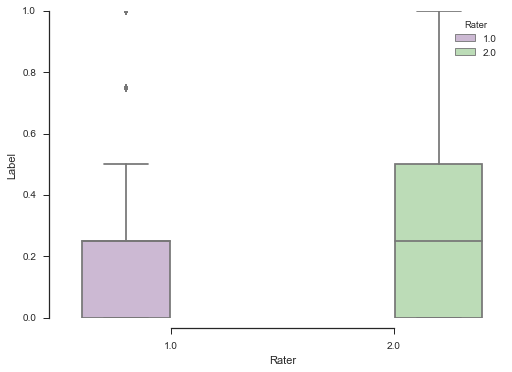

In [17]:
label_boxplot(label_1, label_2)

#### 3. Unbalanced sample <a name="unbalance"></a>

In the view of what we observed in the [previous](#rater12) section, we see that our sample suffers of the lack of samples that are recognized as *dark skin* or *very dark skin*. We show more clearly with the following plot the unbalancement. In particular we see that both the *Rater 1* and *Rater 2* classify in the first three classes more than the 50%.

In [60]:
stacked_plot(label_1,label_2)
tls.embed("https://plot.ly/~crimenghini/0")

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~crimenghini/0 or inside your plot.ly account where it is named 'stacked-bar'


This verification implies important consideration for the further analysis. 
1. We redifine the goal of our analysis as a *Binary Classification* problem. We consider it enough to distinguish a "light skin" player from a "dark skin". In particular the Labels are encoded according to the intervals defined [above](#target). This choice can help us in facing the *unbalancement* of our sample and reduce the complexity of our classification problem. 
2. So far we used the *Accuracy* metric in order to evaluate the accuracy of the model. We will replace it with some other metric. The reason behind it comes from the definition of the accuracy. It is a ratio of the correct prediction over the total sample to predict. Due to the presence of a class (*light skin*) that represents the majority in the sample, the classifier is able to classify this class well. In particular it tends to classify all the observation as that class (we will look at the confusion matrices later). Thus, the accuracy results to be very good just because of the high precence of the class in the data.

Thus, we encode the labels according to the binary classification problem. The function is stored in [`data_preprocessing`](data_preprocessing.py) lybrary.

In [61]:
label_1 = label_1.apply(binary_labels)
label_2 = label_2.apply(binary_labels)

In [62]:
players.drop('rater1', axis = 1, inplace = True)

In [63]:
players.drop('rater2', axis= 1, inplace = True)

### Baseline model  <a name="baseline"></a>

#### Preprocess variable to be used as input for the classifier

In [ ]:
players['birthday'] = players['birthday'].apply(lambda x: float(x.split('.')[-1]))

In [ ]:
def encode_string_variable(df, attribute):
    
    df[attribute] = df[attribute].fillna('Unknown')
    
    le = preprocessing.LabelEncoder()
    
    le.fit(df[attribute])
    
    df[attribute] = le.transform(df[attribute]) 

In [ ]:
# Get the string variables
object_features = [i for i in players.columns if players[i].dtypes == 'object']
numerical_features = [i for i in players.columns if (players[i].dtypes == 'int64' or players[i].dtypes == 'float64') and len(players[i].unique()) > 12]

In [ ]:
for feature in object_features:
    encode_string_variable(players, feature)

##### Categorise features

In [ ]:
numerical_features

In [ ]:
def create_bins(df, attribute):
    # Get the whiskers values
    B = plt.boxplot(df[attribute])
    plt.close()
    min_max = [item.get_ydata()[1] for item in B['whiskers']]

    # Compute the Skew-test
    skew_pvalue = skewtest(df[attribute][df[attribute] >= min_max[0]])[1]
    
    if skew_pvalue < 0.05:
        bins = np.histogram(df[attribute], bins = 'doane')[1]
        bins_interval = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]
    else:
        bins = np.histogram(players[attribute], bins = 'auto')[1]
        bins_interval = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]
    
    return bins_interval

In [ ]:
def categorisation(bins_intervals,x):
    
    classes = range(len(bins_intervals))
    for i in classes:
        if  bins_intervals[i][0] <= x < bins_intervals[i][1]:
            return classes[i]
    
    return classes[-1]   

In [ ]:
for i in range(len(numerical_features)):
    players[numerical_features[i]] = players[numerical_features[i]].apply(partial(categorisation, create_bins(players, numerical_features[i])))

In [ ]:
players

In [ ]:
#describe(players[numerical_features[1]])

In [ ]:
#np.histogram(players[numerical_features[1]], bins = 'doane')

In [ ]:
#describe(players[numerical_features[2]])

In [ ]:
#np.histogram(players[numerical_features[2]], bins = 'doane')

In [ ]:
#describe(players[numerical_features[3]])

In [ ]:
#np.histogram(players[numerical_features[3]], bins = 'doane')

In [ ]:
#describe(players[numerical_features[4]])

In [ ]:
#np.histogram(players[numerical_features[4]], bins = 'doane')

In [ ]:
#describe(players[numerical_features[5]])

In [ ]:
#np.histogram(players[numerical_features[5]], bins = 'doane')

In [ ]:
#describe(players[numerical_features[6]])

In [ ]:
#np.histogram(players[numerical_features[6]], bins = 'doane')

In [ ]:
#describe(players[numerical_features[7]])

In [ ]:
#np.histogram(players[numerical_features[7]], bins = 'auto')

In [ ]:
#describe(players[numerical_features[8]])

In [ ]:
#np.histogram(players[numerical_features[8]], bins = 'doane')

In [ ]:
#describe(players[numerical_features[9]])

In [ ]:
#np.histogram(players[numerical_features[9]], bins = 'doane')

In [ ]:
#describe(players[numerical_features[10]])

In [ ]:
#np.histogram(players[numerical_features[10]], bins = 'doane')

In [ ]:
#describe(players[numerical_features[11]])

In [ ]:
#np.histogram(players[numerical_features[11]], bins = 'doane')

#### Split train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(players, label_1, test_size=0.33, random_state=42)

In [ ]:
weight_class = y_train.value_counts()/len(y_train)

In [ ]:
weight_class

In [ ]:
sample_weights = []
for i in y_train:
    sample_weights += [weight_class[i]]

In [ ]:
y_train_2, y_test_2 = label_2[y_train.index], label_2[y_test.index]

In [ ]:
forest = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')

In [ ]:
train_forest = forest.fit(X_train, y_train, sample_weight= sample_weights)

In [ ]:
a = train_forest.predict(X_test)

In [ ]:
train_forest.score(X_test, y_test)

In [ ]:
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

In [ ]:
multi_label =  np.array([ y_train, y_train_2]).T
multi_label_test = np.array([ y_test, y_test_2]).T

In [ ]:
multi_target_forest.fit(X_train, multi_label, sample_weight= sample_weights).score(X_test, multi_label_test)

In [ ]:
classifier_1 = np.array(classifier_1)

In [ ]:
for i in range(5):
    print ('TEST', len(y_test[y_test == i]), 'class', i)
    print ('PREDICTOR', len(classifier_1[classifier_1 == i]), 'class', i)
    print ('*'*20)

In [ ]:
len(classifier_1)

In [ ]:
len(y_test[y_test == 0])

In [ ]:
len(classifier_1[classifier_1 == 0])

In [ ]:
multi_target_forest.fit(X_train, multi_label).score(X_test, multi_label_test)

In [ ]:
sum(y_test == classifier_1)/len(y_test)

In [ ]:
classifier_1

In [ ]:
y_test

### Find the model <a name="tuning"></a>

### *BONUS* <a name="bonus"></a>

## Cluster players with dark and light skin colors <a name="task2"></a>